<h1>Feedback Prize - English Language Learning</h1>

<h2>Reading data</h2>

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [18]:
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [19]:
test.head()

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


<h2>Wordcloud Visualization</h2>

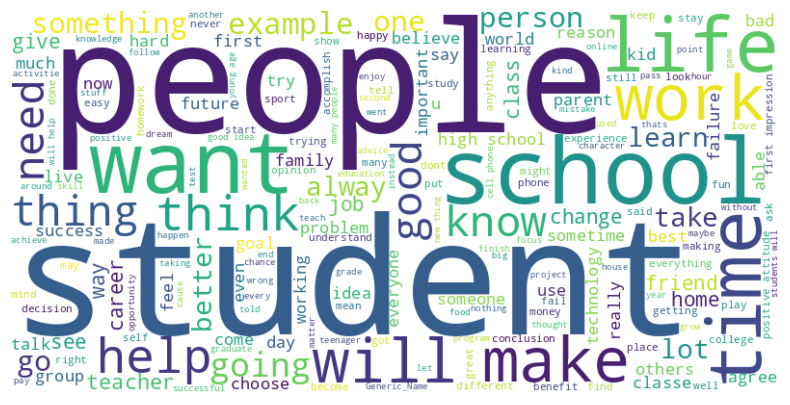

In [20]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white', width=800, height=400).generate(''.join(train.full_text))

plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<h2>Preprocessing</h2>

In [108]:
MAX_WORDS = 1300

def tokenize(df):
    tokenizer = Tokenizer(num_words = MAX_WORDS, oov_token='<OOV>')

    tokenizer.fit_on_texts(df.full_text)

    word_index = tokenizer.word_index
    sequences = tokenizer.texts_to_sequences(df.full_text)

    padded = pad_sequences(sequences, padding='post', maxlen=MAX_WORDS)
    tokenized_df = pd.DataFrame(padded, columns=["word_"+str(i) for i in range(0, MAX_WORDS)])
    return pd.concat([df, tokenized_df], axis=1)

tokenized_train = tokenize(train)
tokenized_test = tokenize(test)

<h2>Model building</h2>

In [109]:
features = ["word_"+str(i) for i in range(0, MAX_WORDS)]
pred_labels = ["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]

X = tokenized_train[features]
y = tokenized_train[pred_labels]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_val.shape", X_val.shape, "y_val.shape", y_val.shape)

X_train.shape (3128, 1300) y_train.shape (3128, 6)
X_val.shape (783, 1300) y_val.shape (783, 6)


In [117]:
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models=[None] * len(lambdas)
for i in range(len(lambdas)):
    lambda_ = lambdas[i]

    inputs = keras.Input(shape=(MAX_WORDS,))
    flatten = keras.layers.Flatten()
    dense1 = keras.layers.Dense(500, activation = 'relu')
    dense2 = Dense(125, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_))
    dense3 = Dense(125, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_))
    dense4 = keras.layers.Dense(6)

    x = flatten(inputs)
    x = dense1(x)
    outputs = dense4(x)

    models[i] = keras.Model(inputs = inputs, outputs = outputs)

    models[i].compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )
    models[i].fit(
        X_train, y_train,
        epochs=1000
    )
    print(f"finished lambda: {lambda_}")

Epoch 1/1000
98/98 [==============================] - 1s 6ms/step - loss: 112267.1641
Epoch 2/1000
98/98 [==============================] - 1s 6ms/step - loss: 301.8302
Epoch 3/1000
98/98 [==============================] - 1s 6ms/step - loss: 10.5979
Epoch 4/1000
98/98 [==============================] - 1s 6ms/step - loss: 9.9759
Epoch 5/1000
98/98 [==============================] - 1s 6ms/step - loss: 9.7280
Epoch 6/1000
98/98 [==============================] - 1s 6ms/step - loss: 9.4083
Epoch 7/1000
98/98 [==============================] - 1s 6ms/step - loss: 9.0519
Epoch 8/1000
98/98 [==============================] - 1s 6ms/step - loss: 8.7763
Epoch 9/1000
98/98 [==============================] - 1s 6ms/step - loss: 8.5105
Epoch 10/1000
98/98 [==============================] - 1s 6ms/step - loss: 8.2388
Epoch 11/1000
98/98 [==============================] - 1s 6ms/step - loss: 7.9615
Epoch 12/1000
98/98 [==============================] - 1s 6ms/step - loss: 7.6793
Epoch 13/1000
98/

In [118]:
best_score = 100000
best_model = 0
for m in models:
    score = m.evaluate(X_val, y_val)
    print(score)
    if score < best_score:
        best_score = score
        best_model = m

25/25 [==============================] - 0s 3ms/step - loss: 0.4391
0.43910059332847595
25/25 [==============================] - 0s 4ms/step - loss: 0.4399
0.4399416744709015
25/25 [==============================] - 0s 4ms/step - loss: 0.4394
0.43942248821258545
25/25 [==============================] - 0s 3ms/step - loss: 0.4394
0.4393692910671234
25/25 [==============================] - 0s 3ms/step - loss: 0.4395
0.43946000933647156
25/25 [==============================] - 0s 4ms/step - loss: 0.4397
0.4396812319755554
25/25 [==============================] - 0s 4ms/step - loss: 0.4419
0.4418926537036896


In [97]:
print("prev_score: ", best_score)
best_model.fit(X_val, y_val, epochs=100)
score = best_model.evaluate(X_val, y_val)
print("Eval Score: ", score)


prev_score:  0.4391670227050781
Epoch 1/100
25/25 [==============================] - 0s 7ms/step - loss: 0.4396
Epoch 2/100
25/25 [==============================] - 0s 7ms/step - loss: 0.4393
Epoch 3/100
25/25 [==============================] - 0s 6ms/step - loss: 0.4395
Epoch 4/100
25/25 [==============================] - 0s 7ms/step - loss: 0.4392
Epoch 5/100
25/25 [==============================] - 0s 7ms/step - loss: 0.4393
Epoch 6/100
25/25 [==============================] - 0s 7ms/step - loss: 0.4392
Epoch 7/100
25/25 [==============================] - 0s 7ms/step - loss: 0.4391
Epoch 8/100
25/25 [==============================] - 0s 7ms/step - loss: 0.4393
Epoch 9/100
25/25 [==============================] - 0s 7ms/step - loss: 0.4395
Epoch 10/100
25/25 [==============================] - 0s 7ms/step - loss: 0.4393
Epoch 11/100
25/25 [==============================] - 0s 7ms/step - loss: 0.4392
Epoch 12/100
25/25 [==============================] - 0s 7ms/step - loss: 0.4391
Epoch

In [98]:
score = best_model.evaluate(X_train, y_train)
print("Train Score: ", score)

98/98 [==============================] - 0s 3ms/step - loss: 0.4247
Train Score:  0.4247346818447113


In [119]:
X_sub = tokenized_test[features]
best_model.predict(X_sub)

1/1 [==============================] - 0s 85ms/step


array([[3.1055906, 3.0235023, 3.2397332, 3.1262314, 3.0413263, 3.0930033],
       [3.1055906, 3.0235023, 3.2397332, 3.1262314, 3.0413263, 3.0930033],
       [3.1055906, 3.0235023, 3.2397332, 3.1262314, 3.0413263, 3.0930033]],
      dtype=float32)